In [707]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, BayesianRidge, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
import warnings
warnings.filterwarnings("ignore")
import math
%matplotlib inline

In [2]:
## This file provides starter code for extracting features from the xml files and
## for doing some learning.
##
## The basic set-up: 
## ----------------
## main() will run code to extract features, learn, and make predictions.
## 
## extract_feats() is called by main(), and it will iterate through the 
## train/test directories and parse each xml file into an xml.etree.ElementTree, 
## which is a standard python object used to represent an xml file in memory.
## (More information about xml.etree.ElementTree objects can be found here:
## http://docs.python.org/2/library/xml.etree.elementtree.html
## and here: http://eli.thegreenplace.net/2012/03/15/processing-xml-in-python-with-elementtree/)
## It will then use a series of "feature-functions" that you will write/modify
## in order to extract dictionaries of features from each ElementTree object.
## Finally, it will produce an N x D sparse design matrix containing the union
## of the features contained in the dictionaries produced by your "feature-functions."
## This matrix can then be plugged into your learning algorithm.
##
## The learning and prediction parts of main() are largely left to you, though
## it does contain code that randomly picks class-specific weights and predicts
## the class with the weights that give the highest score. If your prediction
## algorithm involves class-specific weights, you should, of course, learn 
## these class-specific weights in a more intelligent way.
##
## Feature-functions:
## --------------------
## "feature-functions" are functions that take an ElementTree object representing
## an xml file (which contains, among other things, the sequence of system calls a
## piece of potential malware has made), and returns a dictionary mapping feature names to 
## their respective numeric values. 
## For instance, a simple feature-function might map a system call history to the
## dictionary {'first_call-load_image': 1}. This is a boolean feature indicating
## whether the first system call made by the executable was 'load_image'. 
## Real-valued or count-based features can of course also be defined in this way. 
## Because this feature-function will be run over ElementTree objects for each 
## software execution history instance, we will have the (different)
## feature values of this feature for each history, and these values will make up 
## one of the columns in our final design matrix.
## Of course, multiple features can be defined within a single dictionary, and in
## the end all the dictionaries returned by feature functions (for a particular
## training example) will be unioned, so we can collect all the feature values 
## associated with that particular instance.
##
## Two example feature-functions, first_last_system_call_feats() and 
## system_call_count_feats(), are defined below.
## The first of these functions indicates what the first and last system-calls 
## made by an executable are, and the second records the total number of system
## calls made by an executable.
##
## What you need to do:
## --------------------
## 1. Write new feature-functions (or modify the example feature-functions) to
## extract useful features for this prediction task.
## 2. Implement an algorithm to learn from the design matrix produced, and to
## make predictions on unseen data. Naive code for these two steps is provided
## below, and marked by TODOs.
##
## Computational Caveat
## --------------------
## Because the biggest of any of the xml files is only around 35MB, the code below 
## will parse an entire xml file and store it in memory, compute features, and
## then get rid of it before parsing the next one. Storing the biggest of the files 
## in memory should require at most 200MB or so, which should be no problem for
## reasonably modern laptops. If this is too much, however, you can lower the
## memory requirement by using ElementTree.iterparse(), which does parsing in
## a streaming way. See http://eli.thegreenplace.net/2012/03/15/processing-xml-in-python-with-elementtree/
## for an example. 

import os
from collections import Counter
try:
    import xml.etree.cElementTree as ET
except ImportError:
    import xml.etree.ElementTree as ET
import numpy as np
from scipy import sparse

import util


def extract_feats(ffs, direc="train", global_feat_dict=None):
    """
    arguments:
      ffs are a list of feature-functions.
      direc is a directory containing xml files (expected to be train or test).
      global_feat_dict is a dictionary mapping feature_names to column-numbers; it
      should only be provided when extracting features from test data, so that 
      the columns of the test matrix align correctly.

    returns: 
      a sparse design matrix, a dict mapping features to column-numbers,
      a vector of target classes, and a list of system-call-history ids in order 
      of their rows in the design matrix.
      
      Note: the vector of target classes returned will contain the true indices of the
      target classes on the training data, but will contain only -1's on the test
      data
    """
    fds = [] # list of feature dicts
    classes = []
    ids = [] 
    for datafile in os.listdir(direc):
        # extract id and true class (if available) from filename
        id_str,clazz = datafile.split('.')[:2]
        ids.append(id_str)
        # add target class if this is training data
        try:
            classes.append(util.malware_classes.index(clazz))
        except ValueError:
            # we should only fail to find the label in our list of malware classes
            # if this is test data, which always has an "X" label
            assert clazz == "X"
            classes.append(-1)
        rowfd = {}
        # parse file as an xml document
        tree = ET.parse(os.path.join(direc,datafile))
        # accumulate features
        [rowfd.update(ff(tree)) for ff in ffs]
        fds.append(rowfd)
        
    X,feat_dict = make_design_mat(fds,global_feat_dict)
    return X, feat_dict, np.array(classes), ids


def make_design_mat(fds, global_feat_dict=None):
    """
    arguments:
      fds is a list of feature dicts (one for each row).
      global_feat_dict is a dictionary mapping feature_names to column-numbers; it
      should only be provided when extracting features from test data, so that 
      the columns of the test matrix align correctly.
       
    returns: 
        a sparse NxD design matrix, where N == len(fds) and D is the number of
        the union of features defined in any of the fds 
    """
    if global_feat_dict is None:
        all_feats = set()
        [all_feats.update(fd.keys()) for fd in fds]
        feat_dict = dict([(feat, i) for i, feat in enumerate(sorted(all_feats))])
    else:
        feat_dict = global_feat_dict
        
    cols = []
    rows = []
    data = []        
    for i in xrange(len(fds)):
        temp_cols = []
        temp_data = []
        for feat,val in fds[i].iteritems():
            try:
                # update temp_cols iff update temp_data
                temp_cols.append(feat_dict[feat])
                temp_data.append(val)
            except KeyError as ex:
                if global_feat_dict is not None:
                    pass  # new feature in test data; nbd
                else:
                    raise ex

        # all fd's features in the same row
        k = len(temp_cols)
        cols.extend(temp_cols)
        data.extend(temp_data)
        rows.extend([i]*k)

    assert len(cols) == len(rows) and len(rows) == len(data)
   

    X = sparse.csr_matrix((np.array(data),
                   (np.array(rows), np.array(cols))),
                   shape=(len(fds), len(feat_dict)))
    return X, feat_dict
    

## Here are two example feature-functions. They each take an xml.etree.ElementTree object, 
# (i.e., the result of parsing an xml file) and returns a dictionary mapping 
# feature-names to numeric values.
## TODO: modify these functions, and/or add new ones.
def first_last_system_call_feats(tree):
    """
    arguments:
      tree is an xml.etree.ElementTree object
    returns:
      a dictionary mapping 'first_call-x' to 1 if x was the first system call
      made, and 'last_call-y' to 1 if y was the last system call made. 
      (in other words, it returns a dictionary indicating what the first and 
      last system calls made by an executable were.)
    """
    c = Counter()
    in_all_section = False
    first = True # is this the first system call
    last_call = None # keep track of last call we've seen
    for el in tree.iter():
        # ignore everything outside the "all_section" element
        if el.tag == "all_section" and not in_all_section:
            in_all_section = True
        elif el.tag == "all_section" and in_all_section:
            in_all_section = False
        elif in_all_section:
            if first:
                c["first_call-"+el.tag] = 1
                first = False
            last_call = el.tag  # update last call seen
            
    # finally, mark last call seen
    c["last_call-"+last_call] = 1
    return c

def system_call_count_feats(tree):
    """
    arguments:
      tree is an xml.etree.ElementTree object
    returns:
      a dictionary mapping 'num_system_calls' to the number of system_calls
      made by an executable (summed over all processes)
    """
    c = Counter()
    in_all_section = False
    for el in tree.iter():
        # ignore everything outside the "all_section" element
        if el.tag == "all_section" and not in_all_section:
            in_all_section = True
        elif el.tag == "all_section" and in_all_section:
            in_all_section = False
        elif in_all_section:
            c['num_system_calls'] += 1
    return c

## The following function does the feature extraction, learning, and prediction
def main():
    train_dir = "train"
    test_dir = "test"
    outputfile = "mypredictions.csv"  # feel free to change this or take it as an argument
    
    # TODO put the names of the feature functions you've defined above in this list
    ffs = [first_last_system_call_feats, system_call_count_feats]
    
    # extract features
    print "extracting training features..."
    X_train,global_feat_dict,t_train,train_ids = extract_feats(ffs, train_dir)
    print "done extracting training features"
    print
    
    # TODO train here, and learn your classification parameters
    print "learning..."
    learned_W = np.random.random((len(global_feat_dict),len(util.malware_classes)))
    print "done learning"
    print
    
    # get rid of training data and load test data
    del X_train
    del t_train
    del train_ids
    print "extracting test features..."
    X_test,_,t_ignore,test_ids = extract_feats(ffs, test_dir, global_feat_dict=global_feat_dict)
    print "done extracting test features"
    print
    
    # TODO make predictions on text data and write them out
    print "making predictions..."
    preds = np.argmax(X_test.dot(learned_W),axis=1)
    print "done making predictions"
    print
    
    print "writing predictions..."
    util.write_predictions(preds, test_ids, outputfile)
    print "done!"
    

In [3]:
train_dir = "train"
test_dir = "test"
outputfile = "mypredictions.csv"  # feel free to change this or take it as an argument

# TODO put the names of the feature functions you've defined above in this list
ffs = [first_last_system_call_feats, system_call_count_feats]

# extract features
print "extracting training features..."
X_train,global_feat_dict,t_train,train_ids = extract_feats(ffs, train_dir)
print "done extracting training features"

extracting training features...
done extracting training features


In [4]:
X_train.shape

(3086, 31)

### Feature Engineering TODO Roger to add your input

In [226]:
import os
path = os.getcwd() + '/train'

from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]

In [227]:
onlyfiles[1]

'00278ec420236020d6121dffe0cc20034422e7228.Lipler.xml'

In [6]:
import xml.etree.ElementTree as ET
from collections import Counter
def get_tag_counts(filename):
    tree = ET.parse(filename)
    tags = [elem.tag for elem in tree.iter()]
    tags_counts = Counter(tags)
    return tags_counts

def get_global_tag_counts(ids):
    global_tag_counts = dict()
    for filename in ids:
        full_name = 'train/' + str(filename)
        tag_counts = get_tag_counts(full_name)
        file_id = filename.split('.')[0]
        global_tag_counts[file_id] = tag_counts
    return global_tag_counts

#### If a tag appears

In [247]:
def get_if_substring(filename, string):
    content = ""
    with open(filename, 'r') as myfile:
        content= content + myfile.read().replace('\n', '')
    if string in content:
        print filename
        filename_split = filename.split('.')
#         if filename_split[1] != 'Zbot':
#             print content

In [239]:
def get_global_substring_counts(ids, string):
    global_tag_counts = dict()
    for filename in ids:
        full_name = 'train/' + str(filename)
        get_if_substring(full_name, string)
#         file_id = filename.split('.')[0]
#         global_tag_counts[file_id] = tag_counts
#     return global_tag_counts

In [272]:
get_global_substring_counts(onlyfiles, "HKEY_CURRENT_USER\Software\Live-Player")

train/00278ec420236020d6121dffe0cc20034422e7228.Lipler.xml
train/08857259ae56a73e7120c03419807edc25fa9e5cd.Lipler.xml
train/0ea6b383181b58496a761991b79e21e8f4eec834b.Lipler.xml
train/136a132c84d8b565f65a0Dd8ad0e69371471f08bf.Lipler.xml
train/1b47944bfc08906fd0ec92e415944992fdd6f8143.Lipler.xml
train/28334103d92735c5699d6b1df844f22e31ad3247c.Lipler.xml
train/41154e10db67e500463e66123d70fdD1393a51fee.Lipler.xml
train/44964361cace61047fFdd416074820c50bcdc943a.Lipler.xml
train/44a0826b90f2e8a1647531bf39ba998ec471b7c65.Lipler.xml
train/4605240d86bf95f17ac0648f95972a47b285a6d51.Lipler.xml
train/59f364cd972bd45238bf6ddf9089123ba8d691635.Lipler.xml
train/6b84e7dccc61dae8062a82277c45ce728b867ceb4.Lipler.xml
train/7dcaf50ffb748acbc33397efa04c86ebd30d52dd9.Lipler.xml
train/80b70c50da746241e60f4e2e1861b19c60d5a9d48.Lipler.xml
train/8e4360c7edabc4fbc8f3973c60d65a0cd30fa5548.Lipler.xml
train/94d7ce5e48e6564e603927241bd7b26415050711f.Lipler.xml
train/a566678182f849505c6e2f4f2937871332afa3791.Lipler.x

In [275]:
get_global_substring_counts(onlyfiles, "sdra64.exe")

train/0106c08559ba2663a7d4da40b3415c852408eb256.Zbot.xml
train/0a8e69f80f39b18a78ca7B778a4efb029e7b42fbf.Zbot.xml
train/14f4736e38429afa74147aff575b7a10d2a230ede.Zbot.xml
train/2a4444ebf076c127cb58fb164de6a3b71bafc48c9.Zbot.xml
train/34ed0c3e78fb046da6da2a1db93709b2157d10e8c.Zbot.xml
train/391c7d6de594fd890c91c4ae0588d49f52b7a5918.Zbot.xml
train/3d0caea31b26ede48de93c1fe92ed7cacfa01fbb0.Zbot.xml
train/3db6d7683814c2d64abe33ef46487e2b7ead83b4b.Zbot.xml
train/5f9b5e58a90d1169bceddb2507d8c71fbf8d02e86.Zbot.xml
train/6634423c3f56ef2d41e01f0fb61b6a977bc4cde70.AutoRun.xml
train/668e2fcb612f40eb4fe11d083a57914c913654ac7.Zbot.xml
train/6ddd0e1636a21af6bdb344b0217046bDad3aae3f9.Zbot.xml
train/77e127c1d409a9cdbd61801918eacac834c45d0a5.Zbot.xml
train/8dd84ad3840ca513ef930fe47ae4d682300b6d71c.Zbot.xml
train/94071d86afd900448a39e7c945499808a02674c9a.Zbot.xml
train/a6a02f76d8327a3b6cf46f5e690d1996203159db8.Zbot.xml
train/b5413511ab81fbc7a51209757c18bd5905c68dbb3.Zbot.xml
train/b9a0a0e97ec18acc82eab0

In [251]:
content= ""
with open('train/ff2b2da00bba80c2a3d3071a5bf345a501f5Dd93e.Zbot.xml', 'r') as myfile:
        content= content + myfile.read().replace('\n', '')
content


'<?xml version="1.0"?>\r<processes>\r<process index="1" pid="1180" filename="c:\\f08bf352955cc7d03cc6009636940f1e.EX" filename_hash="hash_error" filesize="360960" md5="f08bf352955cc7d03cc6009636940f1e" sha1="ff2b2da00bba80c2a3d3071a5bf345a501f5d93e" username="Administrator" parentindex="0" starttime="00:00.171" terminationtime="00:04.515" startreason="AnalysisTarget" terminationreason="NormalTermination" executionstatus="OK" applicationtype="Win32Application">\r<thread tid="1176">\r<all_section>\r<load_image filename="c:\\f08bf352955cc7d03cc6009636940f1e.EX" successful="1" address="&#x24;400000" end_address="&#x24;415000" size="86016" filename_hash="hash_error"/>\r<load_dll filename="C:\\WINDOWS\\system32\\ntdll.dll" successful="1" address="&#x24;7C910000" end_address="&#x24;7C9C9000" size="757760" filename_hash="e753d19a2e3b98b2b3b8f02f276092096d10f22d"/>\r<load_dll filename="C:\\WINDOWS\\system32\\kernel32.dll" successful="1" address="&#x24;7C800000" end_address="&#x24;7C908000" size

#### Most common strings

In [11]:
def get_common_strings(filename):
    content = ""
    with open(filename, 'r') as myfile:
        content= content + myfile.read().replace('\n', '')
    content_strings = Counter(content.split(' '))
    return content_strings

In [12]:
def get_global_string_counts(ids):
    global_tag_counts = dict()
    for filename in ids:
        full_name = 'train/' + str(filename)
        tag_counts = get_common_strings(full_name)
        file_id = filename.split('.')[0]
        global_tag_counts[file_id] = tag_counts
    return global_tag_counts

In [13]:
global_string_counts = get_global_string_counts(onlyfiles)

#### Get the tag counts for all files

In [ ]:
global_tag_counts = get_global_tag_counts(onlyfiles)

In [109]:
len(global_tag_counts.keys()), len(train_ids)

(3086, 3086)

In [116]:
global_tags = []
for tag_id in global_tag_counts.keys():
    global_tags= global_tags + global_tag_counts[tag_id].keys()

In [204]:
all_tags = set(global_tags)
len(all_tags)

106

In [59]:
get_tag_counts('train/0a6cbeee24cd37e42b5698319f9af6ebbed74395c.None.xml')

Counter({'all_section': 5,
         'check_for_debugger': 2,
         'com_create_instance': 2,
         'com_get_class_object': 1,
         'create_file': 1,
         'create_mutex': 8,
         'create_process': 1,
         'create_thread': 2,
         'create_window': 8,
         'destroy_window': 42,
         'enum_keys': 4,
         'enum_values': 1,
         'enum_window': 52,
         'find_file': 6,
         'find_window': 10,
         'get_file_attributes': 7,
         'get_system_directory': 15,
         'get_windows_directory': 2,
         'kill_process': 2,
         'load_dll': 133,
         'load_image': 3,
         'open_file': 15,
         'open_key': 96,
         'open_process': 6,
         'process': 3,
         'processes': 1,
         'query_value': 242,
         'set_file_attributes': 1,
         'set_file_time': 1,
         'set_windows_hook': 2,
         'show_window': 4,
         'sleep': 2,
         'thread': 5,
         'vm_protect': 36})

#### Analyze how different each is

In [14]:
# TODO BElinda
len(t_train)

3086

In [15]:
df = pd.DataFrame()
df['train_id'] = train_ids
df['tag_counts'] = [global_tag_counts[train_id] for train_id in train_ids]
# df['total_count'] = [1 for train_id in train_ids]
df['class'] = t_train
df['string_counts'] = [global_string_counts[train_id] for train_id in train_ids]
grouped = df.groupby('class')

NameError: name 'global_tag_counts' is not defined

In [290]:
len(train_ids)

3086

In [ ]:
summary = grouped.agg(['count', 'sum'])['tag_counts']
summary

In [190]:
summary['count'][0]

114

In [205]:
all_tags

{'accept_socket',
 'add_netjob',
 'all_section',
 'bind_socket',
 'change_service_config',
 'check_for_debugger',
 'com_create_instance',
 'com_createole_object',
 'com_get_class_object',
 'connect',
 'connect_socket',
 'control_service',
 'copy_file',
 'create_directory',
 'create_file',
 'create_interface',
 'create_key',
 'create_mailslot',
 'create_mutex',
 'create_namedpipe',
 'create_open_file',
 'create_process',
 'create_process_as_user',
 'create_process_nt',
 'create_service',
 'create_socket',
 'create_thread',
 'create_thread_remote',
 'create_window',
 'delete_file',
 'delete_key',
 'delete_service',
 'delete_share',
 'delete_value',
 'destroy_window',
 'download_file',
 'download_file_to_cache',
 'dump_line',
 'enum_handles',
 'enum_items',
 'enum_keys',
 'enum_modules',
 'enum_processes',
 'enum_services',
 'enum_share',
 'enum_subtypes',
 'enum_types',
 'enum_user',
 'enum_values',
 'enum_window',
 'exit_windows',
 'find_file',
 'find_window',
 'get_computer_name',
 'ge

In [210]:
def get_percentage_appearance(term):
    values = []
    for class_id in summary.index:
        value = float(summary['sum'][class_id][term])/float(summary['count'][class_id])
        print str(class_id) + ": " + str(value)
        values.append(value)
    title = "Counts of " + term
    return values, title

0: 1.08771929825
1: 23.46
2: 0.351351351351
3: 0.8125
4: 1.07317073171
5: 0.384615384615
6: 1.64150943396
7: 0.0731707317073
8: 0.134244872592
9: 0.0952380952381
10: 0.79704797048
11: 1.03125
12: 3.49734042553
13: 0.0338983050847
14: 0.775


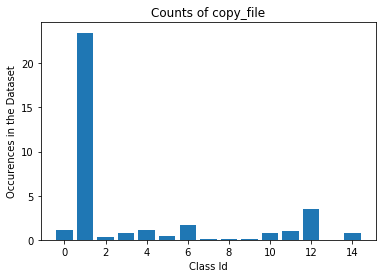

In [218]:
values, title = get_percentage_appearance('copy_file')
plt.bar(summary.index, values)
plt.title(title)
plt.xlabel("Class Id")
plt.ylabel("Occurences in the Dataset")

#### Analyzing the difference for substrings

In [92]:
df = pd.DataFrame()
df['train_id'] = train_ids
# df['tag_counts'] = [global_tag_counts[train_id] for train_id in train_ids]
# df['total_count'] = [1 for train_id in train_ids]
df['class'] = t_train
df['string_counts'] = [global_string_counts[train_id] for train_id in train_ids]
grouped = df.groupby('class')

In [93]:
range(0,15)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [94]:
def get_all_class_counts():
    global_class_string_counts = []
    for class_id in range(0,15):
        class_df = df[df['class']==class_id]
        class_string_counts = Counter()
        for el in class_df['string_counts']:
            class_string_counts = class_0_string_counts + el
        global_class_string_counts.append(class_string_counts)
    return global_class_string_counts

In [97]:
global_class_string_counts = get_all_class_counts()

KeyboardInterrupt: 

In [22]:
class_0 = df[df['class']==0]

In [24]:
class_0.head(5)

,train_id,class,string_counts
22,01942233ac19796d5bf70ead2ec1a72b75b6f494e,0,"{u'hwnd=""&#x24;000101DA""': 1, u'': 48, u'creat..."
28,0212f317d92ddc8616c100acbc42778308babf934,0,"{u'': 204, u'creationdistribution=""CREATE_ALWA..."
31,02349f4deb99e7390afC34267f90f3146a0835d3c,0,"{u'key=""HKEY_LOCAL_MACHINE\SOFTWARE\Microsoft\..."
46,0364ec99767a5b062b818cda4dca5a5f2243cf7c9,0,"{u'hook_address=""&#x24;746B07C3""': 1, u'pid=""1..."
51,03b6918a64c6c4be5d3fd9c5e2d87bb8a404709c7,0,"{u'': 4, u'value=""ProxyEnable""/> <load_dll': 1..."


In [27]:
class_0_string_counts = Counter()
for el in class_0['string_counts']:
    class_0_string_counts = class_0_string_counts + el

In [32]:
class_1 = df[df['class']==1]
class_1_string_counts = Counter()
for el in class_1['string_counts']:
    class_1_string_counts = class_1_string_counts + el

In [36]:
class_0.shape, class_1.shape

((114, 3), (50, 3))

In [88]:
class_0_string_counts.most_common(20), class_1_string_counts.most_common(20)

([('size="4096"', 125584),
  ('behavior="Normal"', 116539),
  ('wantedsize="4"', 111904),
  ('"', 75727),
  ('protect="PAGE_EXECUTE_READWRITE"', 63386),
  ('protect="PAGE_EXECUTE_READ"', 61106),
  ('', 56002),
  ('00', 45870),
  ('filetype="file"', 42704),
  ('desiredaccess="FILE_ANY_ACCESS"', 40029),
  ('address="&#x24;7C882000"', 34378),
  ('20', 26817),
  ('successful="1"', 26500),
  ('address="&#x24;77E14000"', 24971),
  ('srcfile_hash="hash_error"', 24080),
  ('key="HKEY_LOCAL_MACHINE\\SOFTWARE\\Microsoft\\Windows', 22000),
  ('Desktop', 21744),
  ('65', 18531),
  ('flags="FILE_ATTRIBUTE_NORMAL', 18522),
  ('creationdistribution="OPEN_EXISTING"', 17404)],
 [('', 28744),
  ('desiredaccess="FILE_ANY_ACCESS"', 19440),
  ('filetype="file"', 17335),
  ('srcfile_hash="hash_error"', 15950),
  ('successful="1"', 15891),
  ('FILE_SHARE_WRITE"', 7177),
  ('shareaccess="FILE_SHARE_READ', 7139),
  ('size="4096"', 7056),
  ('creationdistribution="OPEN_EXISTING"', 6902),
  ('flags="SECURITY_ANO

#### Final feature matrix

In [4]:
df = pd.read_csv('train223feats.csv')
df = df.drop(['Unnamed: 0'], axis=1)
X_train = np.matrix(df)

In [5]:
X_train.shape

(3086, 223)

In [ ]:
nn.fit(X_train, y_train)

y_valid = nn.predict(X_valid)

score = nn.score(X_test, y_test)

### Approaches
#### Neural Nets

In [41]:
from sknn.mlp import Classifier, Layer

nn = Classifier(
    layers=[
        Layer("Tanh", units=1),
        Layer("Softmax")],
    learning_rate=0.001,
    n_iter=25)

In [42]:
nn.fit(X_train, t_train)

Classifier(batch_size=1, callback=None, debug=False, dropout_rate=None,
      f_stable=0.001,
      hidden0=<sknn.nn.Layer `Tanh`: units=1, name=u'hidden0', frozen=False>,
      layers=[<sknn.nn.Layer `Tanh`: units=1, name=u'hidden0', frozen=False>, <sknn.nn.Layer `Softmax`: units=15, name=u'output', frozen=False>],
      learning_momentum=0.9, learning_rate=0.001, learning_rule=u'sgd',
      loss_type=None, n_iter=25, n_stable=10, normalize=None,
      output=<sknn.nn.Layer `Softmax`: units=15, name=u'output', frozen=False>,
      parameters=None, random_state=None, regularize=None, valid_set=None,
      valid_size=0.0, verbose=None, warning=None, weight_decay=None)

In [52]:
predictions = nn.predict(X_train)
predictions.shape

[(3086, 15)]


(3086, 1)

In [55]:
elements = [el[0] for el in predictions]
sum(elements)/float(8)

3086.0

In [151]:
print cross_val_score(nn, X_train, t_train, cv=5, scoring="accuracy")

[(624, 15)]
[(620, 15)]
[(616, 15)]
[(615, 15)]
[(611, 15)]
[ 0.51602564  0.51935484  0.52272727  0.52357724  0.52536825]


In [56]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)

In [158]:
print cross_val_score(clf, X_train, t_train, cv=5, scoring="accuracy")

[ 0.51602564  0.51935484  0.52272727  0.52357724  0.52536825]


In [57]:
clf.fit(X_train, t_train)
predictions = clf.predict(X_train)

In [58]:
predictions = nn.predict(X_train)
predictions.shape

[(3086, 15)]


(3086, 1)

In [59]:
sum(elements)/float(8)

3086.0

#### Adaboosting

In [353]:
import sklearn
from sklearn.ensemble import AdaBoostClassifier
AB = sklearn.ensemble.AdaBoostClassifier()
AB.fit(X_train, t_train)
print "Adaboosting Classifier"
print cross_val_score(AB, X_train, t_train, cv=5, scoring="accuracy")

Adaboosting Classifier
[ 0.5849359   0.5483871   0.70779221  0.77560976  0.55810147]


## Not best

In [27]:
df = pd.read_csv('train340feats_nosyscall.csv')
df = df.drop(['Unnamed: 0'], axis=1)
X_train = np.matrix(df)
RF = RandomForestClassifier(n_estimators=100)
RF.fit(X_train, t_train)
print "Random Forest Classifier"
print np.mean(cross_val_score(RF, X_train, t_train, cv=5, scoring="accuracy"))

Random Forest Classifier
0.89015337229


In [30]:
df = pd.read_csv('train223feats.csv')
df = df.drop(['Unnamed: 0'], axis=1)
X_train = np.matrix(df)
RF = RandomForestClassifier(n_estimators=100)
RF.fit(X_train, t_train)
print "Random Forest Classifier"
print np.mean(cross_val_score(RF, X_train, t_train, cv=5, scoring="accuracy"))

Random Forest Classifier
0.891457785815


#### Random Forest Extreme

In [318]:
df = pd.read_csv('train156feats.csv')
df = df.drop(['Unnamed: 0'], axis=1)
X_train = np.matrix(df)

In [319]:
RF = RandomForestClassifier(n_estimators=1800)
RF.fit(X_train, t_train)
print "Random Forest Classifier"
print np.mean(cross_val_score(RF, X_train, t_train, cv=5, scoring="accuracy"))

Random Forest Classifier
0.8962959138


In [320]:
df = pd.read_csv('train223feats.csv')
df = df.drop(['Unnamed: 0'], axis=1)
X_train = np.matrix(df)
RF = RandomForestClassifier(n_estimators=1800)
RF.fit(X_train, t_train)
print "Random Forest Classifier"
print np.mean(cross_val_score(RF, X_train, t_train, cv=5, scoring="accuracy"))

Random Forest Classifier
0.895025665461


In [322]:
df = pd.read_csv('train406feats.csv')
df = df.drop(['Unnamed: 0'], axis=1)
X_train = np.matrix(df)
RF = RandomForestClassifier(n_estimators=100)
RF.fit(X_train, t_train)
print "Random Forest Classifier"
print np.mean(cross_val_score(RF, X_train, t_train, cv=5, scoring="accuracy"))

Random Forest Classifier
0.896295661682


In [309]:
feat_importance = RF.feature_importances_
feat_importance_df['406_2'] = feat_importance

In [310]:
feat_importance_df.describe()

,406,406_1,406_2
count,406.000000,406.000000,406.000000
mean,0.002463,0.002463,0.002463
std,0.003875,0.004017,0.003732
min,0.000000,0.000000,0.000000
25%,0.000206,0.000229,0.000225
50%,0.001007,0.000897,0.000939
75%,0.002811,0.002796,0.002774
max,0.024933,0.027463,0.024180


In [311]:
most_important_to_406 = feat_importance_df[feat_importance_df['406'] > .001007]
most_important_to_406_1 = most_important_to_406[most_important_to_406['406_1'] > .001007]
most_important_to_406_2 = most_important_to_406_1[most_important_to_406_1['406_2'] > .001007]

In [312]:
most_important_to_406.to_csv('406mostimportant.csv')

In [313]:
most_important_to_406.index, len(most_important_to_406)

(Int64Index([  3,   8,  16,  23,  36,  41,  43,  46,  49,  50,
             ...
             373, 385, 386, 387, 388, 389, 390, 398, 401, 402],
            dtype='int64', length=203), 203)

In [314]:
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,396,397,398,399,400,401,402,403,404,405
0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,0,0,0,0
1,0,0,0,6,0,0,0,0,1,0,...,1,1,1,1,1,1,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [323]:
best_df = df[list(most_important_to_406.index)]

In [414]:
test_df = pd.read_csv('test406feats.csv')

In [411]:
test_df.head(5)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,396,397,398,399,400,401,402,403,404,405
0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,0,0,0,0
1,1,0,0,0,2,0,0,0,0,0,...,1,1,1,1,1,1,1,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,5,0,0,0,0,1,...,1,1,1,1,1,1,1,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [325]:
best_test_df = test_df[list(most_important_to_406.index)]

In [343]:
df = pd.read_csv('train505feats.csv')
df = df.drop(['Unnamed: 0'], axis=1)
X_train = np.matrix(df)
RF = RandomForestClassifier(n_estimators=100)
RF.fit(X_train, t_train)
print "Random Forest Classifier"
print np.mean(cross_val_score(RF, X_train, t_train, cv=5, scoring="accuracy"))

Random Forest Classifier
0.894370847248


In [344]:
def get_feature_importances():
    
    feat_importance_df = pd.DataFrame()
    for i in range(0,3):
        RF = RandomForestClassifier(n_estimators=100)
        RF.fit(X_train, t_train)
        feat_importance = RF.feature_importances_
        feat_importance_df[str(i)] = feat_importance

    return feat_importance_df

In [345]:
fivehundredfive_df = get_feature_importances()

In [346]:
fivehundredfive_df.describe()

,0,1,2
count,505.000000,505.000000,505.000000
mean,0.001980,0.001980,0.001980
std,0.005448,0.005382,0.005308
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000095,0.000128,0.000148
max,0.034599,0.029453,0.026978


In [347]:
fivehundredfive_most = fivehundredfive_df[(fivehundredfive_df >= .000126).any(axis=1)]

In [348]:
fivehundredfive_most.index

Int64Index([  3,   4,   5,   6,   7,   9,  10,  12,  13,  14,
            ...
            489, 490, 491, 492, 493, 494, 495, 499, 503, 504],
           dtype='int64', length=132)

In [349]:
best_df_505 = df[list(fivehundredfive_most.index)]

In [351]:
test_df = pd.read_csv('test505feats.csv')
best_test_df_505 = test_df[list(fivehundredfive_most.index)]
best_df_505.shape, best_test_df_505.shape

((3086, 132), (3724, 132))

In [352]:
df = pd.read_csv('train537feats.csv')
df = df.drop(['Unnamed: 0'], axis=1)
X_train = np.matrix(df)
RF = RandomForestClassifier(n_estimators=100)
RF.fit(X_train, t_train)
print "Random Forest Classifier"
print np.mean(cross_val_score(RF, X_train, t_train, cv=5, scoring="accuracy"))

Random Forest Classifier
0.894707032426


In [353]:
fivethirtyseven_df = get_feature_importances()

In [354]:
fivethirtyseven_df.describe()

,0,1,2
count,537.000000,537.000000,537.000000
mean,0.001862,0.001862,0.001862
std,0.003087,0.003269,0.003152
min,0.000000,0.000000,0.000000
25%,0.000293,0.000327,0.000334
50%,0.000776,0.000743,0.000760
75%,0.001814,0.001872,0.001717
max,0.027379,0.039345,0.023019


In [355]:
fivethirtyseven_df = fivethirtyseven_df[(fivethirtyseven_df >= .001326).any(axis=1)]

In [356]:
len(fivethirtyseven_df)

229

In [357]:
best_df_537 = df[list(fivethirtyseven_df.index)]

In [361]:
test_df = pd.read_csv('test537feats.csv')
best_test_df_537 = test_df[list(fivethirtyseven_df.index)]
best_df_537.shape, best_test_df_537.shape

((3086, 229), (3724, 229))

In [362]:
df = pd.read_csv('train599feats.csv')
df = df.drop(['Unnamed: 0'], axis=1)
X_train = np.matrix(df)
RF = RandomForestClassifier(n_estimators=100)
RF.fit(X_train, t_train)
print "Random Forest Classifier"
print np.mean(cross_val_score(RF, X_train, t_train, cv=5, scoring="accuracy"))

Random Forest Classifier
0.895995440911


In [363]:
fiveninenine_df = get_feature_importances()

In [364]:
fiveninenine_df.describe()

,0,1,2
count,599.000000,599.000000,599.000000
mean,0.001669,0.001669,0.001669
std,0.003686,0.003779,0.003651
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.001336,0.001298,0.001381
max,0.025347,0.026713,0.024628


In [365]:
fiveninenine_df = fiveninenine_df[(fiveninenine_df >= .001413).any(axis=1)]

In [368]:
best_df_599 = df[list(fiveninenine_df.index)]
best_df_599.shape

(3086, 173)

In [369]:
test_df = pd.read_csv('test599feats.csv')
best_test_df_599 = test_df[list(fiveninenine_df.index)]
best_df_599.shape, best_test_df_599.shape

((3086, 173), (3724, 173))

### Combining most important featuers

In [418]:
overall_best_df = pd.concat([best_df, best_df_505, best_df_537, best_df_599], axis=1)

In [419]:
overall_best_df_dropped = overall_best_df.T.drop_duplicates().T

In [397]:
overall_best_df_dropped

,3,8,16,23,36,41,43,46,49,50,...,388,401,403,407,421,422,557,563,582,589
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,6.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,339.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,5.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [404]:
overall_best_df.columns

Index([u'3', u'8', u'16', u'23', u'36', u'41', u'43', u'46', u'49', u'50',
       ...
       u'586', u'587', u'588', u'589', u'590', u'591', u'592', u'593', u'594',
       u'595'],
      dtype='object', length=737)

In [408]:
sum([str(int(column_id) + 1) for column_id in overall_best_test_df.columns] == overall_best_df.columns)

737

In [435]:
overall_best_test_df = pd.concat([best_test_df, best_test_df_505, best_test_df_537, best_test_df_599], axis=1)

In [436]:
overall_best_test_df.columns = [str(int(column_id) + 1) for column_id in overall_best_test_df.columns]

In [438]:
overall_best_test_df.shape, overall_best_df.shape, sum(overall_best_df.columns == overall_best_test_df.columns)

((3724, 737), (3086, 737), 737)

In [452]:
overall_best_test_df.columns = list(range(0,737))
overall_best_df.columns = list(range(0,737))
overall_best_test_df.shape, overall_best_df.shape, sum(overall_best_df.columns == overall_best_test_df.columns)

((3724, 737), (3086, 737), 737)

In [454]:
overall_best_df_dropped = overall_best_df.T.drop_duplicates().T

In [457]:
len(overall_best_df_dropped.columns)

294

In [460]:
not_in_columns = [column_id for column_id in overall_best_test_df.columns if column_id not in overall_best_df_dropped.columns]

In [462]:
len(not_in_columns), len(overall_best_df_dropped.columns)

(443, 294)

In [463]:
overall_best_test_df[overall_best_df_dropped.columns].shape

(3724, 294)

In [465]:
overall_best_test_df[overall_best_df_dropped.columns].shape, overall_best_df_dropped.shape

((3724, 294), (3086, 294))

### Final Test DF

In [468]:
overall_best_test_df_matching = overall_best_test_df[overall_best_df_dropped.columns]
overall_best_test_df_matching.shape

(3724, 294)

In [469]:
X_test = np.matrix(overall_best_test_df_matching)
X_train = np.matrix(overall_best_df_dropped)

In [279]:
df = pd.read_csv('train537feats.csv')
df = df.drop(['Unnamed: 0'], axis=1)
X_train = np.matrix(df)
RF = RandomForestClassifier(n_estimators=1800)
RF.fit(X_train, t_train)
print "Random Forest Classifier"
print np.mean(cross_val_score(RF, X_train, t_train, cv=5, scoring="accuracy"))

Random Forest Classifier
0.896970430176


In [280]:
df = pd.read_csv('train599feats.csv')
df = df.drop(['Unnamed: 0'], axis=1)
X_train = np.matrix(df)
RF = RandomForestClassifier(n_estimators=1800)
RF.fit(X_train, t_train)
print "Random Forest Classifier"
print np.mean(cross_val_score(RF, X_train, t_train, cv=5, scoring="accuracy"))

Random Forest Classifier
0.897602790921


In [218]:
X_train.shape

(3086, 298)

In [305]:
def get_best_df():
    df = pd.read_csv('train406feats.csv')
    best_df = df[list(most_important_to_406.index)]
    
    print len(most_important_to_406.index)
    print best_df.shape
    
    df = pd.read_csv('train505feats.csv')
    best_df_505 = df[list(fivehundredfive_most.index)]
    print len(fivehundredfive_most.index)
    print best_df_505.shape
    
    df = pd.read_csv('train537feats.csv')
    best_df_537 = df[list(fivethirtyseven_df.index)]
    print len(fivethirtyseven_df.index)
    print best_df_537.shape
    df = pd.read_csv('train599feats.csv')
    best_df_599 = df[list(fiveninenine_df.index)]
    print len(fiveninenine_df.index)
    print best_df_599.shape
    
    overall_best_df = pd.concat([best_df, best_df_505, best_df_537, best_df_599], axis=1)
    print overall_best_df.shape
    print pd.concat([best_df, best_df_505, best_df_537, best_df_599], axis=1).T.drop_duplicates().T.shape
   

In [304]:
get_best_df()

203
(3086, 203)
130
(3086, 130)
235
(3086, 235)
172
(3086, 172)
(3086, 740)
(3086, 286)


In [294]:
print pd.concat([best_df, best_df_505, best_df_537, best_df_599], axis=1).T.drop_duplicates().T.shape

(3086, 298)


In [268]:
np.matrix(best_train_df).shape

(3086, 286)

In [264]:
best_test_df = get_best_df()

In [265]:
np.matrix(best_test_df).shape

(3724, 298)

#### Clustering

In [475]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [364]:
dtc = DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=0)
print "Random Forest Classifier"
print cross_val_score(dtc, X_train, t_train, cv=5, scoring="accuracy")

Random Forest Classifier
[ 0.86698718  0.86774194  0.86363636  0.8601626   0.86579378]


In [366]:
etc = ExtraTreesClassifier(n_estimators=100)
print cross_val_score(etc, X_train, t_train, cv=5, scoring="accuracy")

[ 0.8974359   0.89354839  0.90584416  0.88292683  0.90016367]


In [373]:
gbc = GradientBoostingClassifier(n_estimators=100)
print cross_val_score(gbc, X_train, t_train, cv=5, scoring="accuracy")

[ 0.875       0.88709677  0.89448052  0.88130081  0.87888707]


#### Random Forest

In [481]:
RF = RandomForestClassifier(n_estimators=1800)
print "Random Forest Classifier"
print np.mean(cross_val_score(RF, X_train, t_train, cv=5, scoring="accuracy"))

Random Forest Classifier
0.897930132737


In [482]:
etc = ExtraTreesClassifier(n_estimators=1800)
print np.mean(cross_val_score(etc, X_train, t_train, cv=5, scoring="accuracy"))

0.899868405431


In [523]:
df = pd.read_csv('train160feats.csv')
df = df.drop(['Unnamed: 0'], axis=1)

In [531]:
X_train = np.matrix(df)

In [532]:
RF = RandomForestClassifier(n_estimators=1800)
RF.fit(X_train, t_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1800, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [527]:
df_test = pd.read_csv('test160feats.csv')
df_test = df_test.drop(['Unnamed: 0'], axis=1)

In [533]:
X_test = np.matrix(df_test)
X_test.shape

(3724, 160)

In [534]:
RF_preds = RF.predict(X_test)

In [484]:
etc.fit(X_train, t_train)
etc_preds = etc.predict(X_test)

In [504]:
etc_preds

array([ 8, 10,  8, ...,  8,  8,  8])

In [490]:
original_preds = pd.read_csv('rfpredictions156.csv')

In [536]:
amount = 0
for i in range(0, len(etc_preds)):
    if original_preds['Prediction'][i] == RF_preds[i]:
        amount = amount + 1 

In [537]:
amount / float(len(etc_preds))

0.9731471535982814

In [516]:
df = pd.read_csv('train156feats.csv')
df = df.drop(['Unnamed: 0'], axis=1)
X_train = np.matrix(df)
etc = ExtraTreesClassifier(n_estimators=2500)
print np.mean(cross_val_score(etc, X_train, t_train, cv=5, scoring="accuracy"))

0.894370206814


In [517]:
test_df = pd.read_csv('test156feats.csv')
test_df = test_df.drop(['Unnamed: 0'], axis=1)
X_test = np.matrix(test_df)

In [518]:
etc.fit(X_train, t_train)
etc_preds_156 = etc.predict(X_test)

In [519]:
len(etc_preds_156), len(etc_preds)

(3724, 3724)

In [520]:
amount = 0
for i in range(0, len(etc_preds)):
    if original_preds['Prediction'][i] == etc_preds_156[i]:
        amount = amount + 1 

In [521]:
amount / float(len(etc_preds))

0.9511278195488722

#### Multinomial Bayes

In [65]:
from sklearn.naive_bayes import MultinomialNB
MNNB = MultinomialNB()
print "Multinomial NB"
print cross_val_score(MNNB, X_train, t_train, cv=5, scoring="accuracy")

Multinomial NB
[ 0.19871795  0.64032258  0.35551948  0.63577236  0.53518822]


In [66]:
MNNB.fit(X_train, t_train)
predictions = MNNB.predict(X_train)

In [67]:
def get_prediction_accuracy(predictions, t_train):
    in_both = [i for i, j in zip(predictions, t_train) if i == j]
    print len(in_both) / float(len(predictions))

#### SVM

In [68]:
lin_clf = svm.LinearSVC()
lin_clf.fit(X_train, t_train)
print "SVM Classifier"
print cross_val_score(lin_clf, X_train, t_train, cv=5, scoring="accuracy")

SVM Classifier
[ 0.72596154  0.35967742  0.16396104  0.42601626  0.45499182]


#### Implements One vs Rest and radial basis function

In [69]:
svm = svm.SVC(decision_function_shape='ovr')
svm.fit(X_train, t_train)
print "SVM Classifier"
print cross_val_score(svm, X_train, t_train, cv=5, scoring="accuracy")

SVM Classifier
[ 0.76762821  0.78225806  0.78571429  0.79186992  0.75286416]


### Data Exploration

In [136]:
counts_per_class = Counter(t_train)

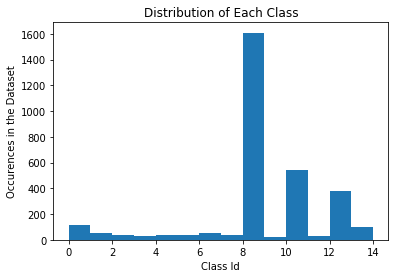

In [89]:
%matplotlib inline
plt.hist(df['class'], bins=14)
plt.title("Distribution of Each Class")
plt.xlabel("Class Id")
plt.ylabel("Occurences in the Dataset")

### Exploring Which Features We Actually Care About

In [374]:
import os
path = os.getcwd() + '/counts'

from os import listdir
from os.path import isfile, join
countfiles = [f for f in listdir(path) if isfile(join(path, f))]
countfiles = countfiles[1:]

In [375]:
dfs = []
for class_id in range(0,15):
    file_name = 'counts/' + str(countfiles[class_id])
    df = pd.read_csv(file_name, names=['name', 'counts'])
    df = df.sort(['counts'], ascending=False)
    df = df.set_index(['name'])
    df = df.dropna()
    dfs.append(df)

In [376]:
all_features = []
for i in range(0,15):
    all_features = all_features + list(dfs[i].index)
all_features = list(set(all_features))

In [285]:
def get_standard_deviation(feature_name):
    feature_values = []
    for i in range(0,15):
        value = 0
        try: 
            value = dfs[i].get_value(feature_name, 'counts')
        except:
            pass

        feature_values.append(value)
    standard_deviation = np.std(feature_values)
    return standard_deviation

In [449]:
def get_most_important_features(feature_name):
    feature_values = []
    for i in range(0,15):
        value = 0
        try: 
            value = dfs[i].get_value(feature_name, 'counts')
        except:
            pass

        feature_values.append(value)
    
    if max(feature_values) >= 0.8:
        features_without_max = [feature_value for feature_value in feature_values if feature_value != max(feature_values)]
        if np.mean(features_without_max) <= 0.4:
            return feature_values
    return None

In [445]:
def get_most_important_features_i(feature_name, i):
    feature_values = []
    for i in range(0,15):
        value = 0
        try: 
            value = dfs[i].get_value(feature_name, 'counts')
        except:
            pass

        feature_values.append(value)
    
    if feature_values[i] >= 0.7:
        features_without_max = [feature_value for feature_value in feature_values if feature_value != feature_values[i]]
        if np.mean(features_without_max) <= 0.2:
            return feature_values
    return None

In [446]:
print get_most_important_features_i('query_value--data--_--', 0)

None


In [447]:
global_feature_frequencies = dict()
for feature_name in all_features:
    try:
        feature_values = get_most_important_features_i(feature_name, 1)
        if feature_values != None:
            global_feature_frequencies[feature_name] = feature_values
    except ValueError as e:
        print e
        print feature_name
        pass

KeyboardInterrupt: 

In [443]:
Counter(global_feature_frequencies).keys()

[]

In [444]:
plt.hist(global_feature_frequencies['create_open_file--creationdistribution--_--always'], bins=14)
plt.title("set_file_attributes--flags-- --file_attribute_archive'")
plt.xlabel("Class Id")
plt.ylabel("Occurences in the Dataset")

KeyError: 'create_open_file--creationdistribution--_--always'

#### Testing

In [450]:
global_feature_frequencies = dict()
for feature_name in all_features:
    try:
        feature_values = get_most_important_features(feature_name)
        if feature_values != None:
            global_feature_frequencies[feature_name] = feature_values
    except ValueError as e:
        print e
        print feature_name
        pass

The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
ko
The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
_char(0x02)__char(0x01)_
The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
:j


In [464]:
import collections
max_classes = []
features_by_max_class = collections.defaultdict(dict)
for feature_name in global_feature_frequencies.keys():
    max_class = global_feature_frequencies[feature_name].index(max(global_feature_frequencies[feature_name]))
    
    max_classes.append(max_class)
    features_by_max_class[max_class][feature_name] = max(global_feature_frequencies[feature_name])

In [487]:
global_feats = []
for i in range(0,15):
    most_common = Counter(features_by_max_class[i]).most_common(20)
    most_common_keys = [key for key, value in most_common] 
    global_feats = most_common_keys + global_feats

In [489]:
len(global_feats)

115

In [488]:
pd.DataFrame(global_feats).to_csv('keyfeaturesformost-medium.csv')

In [457]:
Counter(max_classes)

Counter({1: 26, 2: 46, 3: 11, 5: 5, 6: 126, 8: 1, 10: 45, 12: 18})

In [458]:
len(Counter(global_feature_frequencies).keys())

278

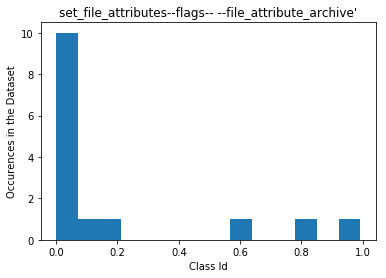

In [432]:
plt.hist(global_feature_frequencies['open_key--key--\\--vba'], bins=14)
plt.title("set_file_attributes--flags-- --file_attribute_archive'")
plt.xlabel("Class Id")
plt.ylabel("Occurences in the Dataset")

In [415]:
pd.DataFrame(Counter(global_feature_frequencies).keys()).to_csv('keyschosen.csv')

In [298]:
optimal = [name for name, val in Counter(global_feature_frequencies).most_common(500)]

In [299]:
pd.DataFrame(optimal).to_csv('optimal_fivehundred.csv')

### Finding Correlated Features

In [343]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=200)
X_train_after_pca = pca.fit_transform(X_train)

In [345]:
RF_pca = RandomForestClassifier(n_estimators=100)
RF_pca.fit(X_train_after_pca, t_train)
print "Random Forest Classifier"
print cross_val_score(RF_pca, X_train_after_pca, t_train, cv=5, scoring="accuracy")

Random Forest Classifier
[ 0.88782051  0.88548387  0.89285714  0.88617886  0.88870704]


### 2 layer TODO BRIAN

In [448]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AffinityPropagation
from sklearn.linear_model import LinearRegression, BayesianRidge, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import warnings
warnings.filterwarnings("ignore")
import math

def scoring(estimator, X, y):
    y_pred = estimator.predict(X)
    return accuracy_score(y, y_pred)

def two_layer_rf(x_train, y_train, x_test,  
                 n_estimators=[1, 10, 25, 35, 50, 75, 100, 125, 150, 175, 200],
                 min_samples_split=[2, 3, 4, 6, 8, 16], 
                 min_samples_leaf=[1, 2, 4, 8, 16, 32], num_features=31, n_jobs=2, debug=False, neutral_class=8):
    """
    Note that neutral_class is usually meant to be the class that is the most common in the dataset
    """
    
    # first we instantiate the RFC used for the binary random forest
    max_features = np.arange(1, stop=num_features, step=5)
    if num_features >= 50:
        max_features = np.arange(1, stop=num_features, step=25)
    
    param_grid = {'n_estimators' : n_estimators, 'max_features' : max_features,
                  'min_samples_split': min_samples_split, 'min_samples_leaf' : min_samples_leaf}
    RFC_bin = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, n_jobs=n_jobs)
    
    # need a binary value to train on for the ys
    y_bin_train = [0 if y == 8 else 1 for y in y_train]
    
    if debug:
        print("beginning fit on binary classifier...")
    RFC_bin.fit(x_train, y_bin_train)
    if debug:
        print("binary fit complete.")
        print("Binary classifier train score: {0}".format(RFC_bin.score(x_train, y_bin_train)))
        print("RFC binary classifier parameters: {0}".format(RFC_bin.best_params_))
    
    # create a mask on the train data to know what to pass to the second classifier
    # and one on the test data to know what we consider to be malware free
    mask_test = RFC_bin.predict(x_test)
    mask_train = RFC_bin.predict(x_train)
    
    if debug:
        print("test_mask: {0}".format(mask_test))
        print("train_mask: {0}".format(mask_train))
        print("The counts on test: {0}".format(np.bincount(mask_test)))
        print("The counts on train: {0}".format(np.bincount(mask_train)))
        
    # now we do a grid search on the second random forest parameters (which will actually provide a class)
    class_train = x_train[np.where(mask_train==1)]
    class_y_train = y_train[np.where(mask_train==1)]
    RFC_class = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, n_jobs=n_jobs)
    if debug:
        print("beginning fit on multiclass classifier...")
    RFC_class.fit(class_train, class_y_train)
    
    if debug:
        print("multiclass fit complete.")
        print("MultiClass classifier train score: {0}".format(RFC_class.score(class_train, class_y_train)))
        print("RFC MultiClass classifier parameters: {0}".format(RFC_class.best_params_))
        
    # which ones we will actually predict on, because the other ones have been assigned to the neutral class
    class_test = x_test[np.where(mask_test==1)]
    pred_class = list(RFC_class.predict(class_test))
    
    # for evaluation purposes, predict on our train data
    # list() allows us to use pop
    pred_class_train = list(RFC_class.predict(class_train))
    
    # we will eventually transform the mask into our final results vector
    # by turning the 0's into the neutral_class and the 1's into 0's
    final_res = ((mask_test * -1) + 1) * neutral_class
    
    # for evaluation purposes
    final_res_train = ((mask_train * -1) + 1) * neutral_class
    
    # merge the lists appropriately
    true_final = [pred_class.pop(0) if x == 0 else x for x in final_res]
    true_final_train = [pred_class_train.pop(0) if x == 0 else x for x in final_res_train]
    
    if debug:
        print("Overall Train Score: {0}".format(accuracy_score(y_train, true_final_train)))
        
    return true_final

In [8]:
two_layer_predictions = two_layer_rf(X_train, t_train, X_test)

NameError: name 'two_layer_rf' is not defined

### 2 LAYER

In [541]:
Counter(RF_preds)

Counter({0: 138,
         1: 58,
         2: 59,
         3: 37,
         4: 41,
         5: 75,
         6: 58,
         7: 59,
         8: 1728,
         9: 111,
         10: 690,
         11: 60,
         12: 497,
         13: 80,
         14: 33})

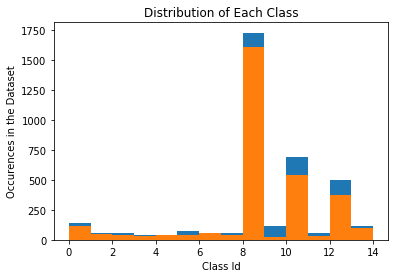

In [543]:
%matplotlib inline
plt.hist(RF_preds, bins=14)
plt.hist(t_train, bins=14)
plt.title("Distribution of Each Class")
plt.xlabel("Class Id")
plt.ylabel("Occurences in the Dataset")

In [713]:
from sklearn.multiclass import OneVsRestClassifier

In [670]:
RF = RandomForestClassifier(n_estimators=100)
ovr_classifier = OneVsRestClassifier(RF, n_jobs=10)

In [548]:
print np.mean(cross_val_score(ovr_classifier, X_train, t_train, cv=5, scoring="accuracy"))

0.89338096567


In [716]:
from sklearn.multiclass import OneVsOneClassifier

In [717]:
ovo_classifier = OneVsRestClassifier(RF, n_jobs=100)

In [718]:
print np.mean(cross_val_score(ovo_classifier, X_train, t_train, cv=5, scoring="accuracy"))

ImportError: [joblib] Attempting to do parallel computing without protecting your import on a system that does not support forking. To use parallel-computing in a script, you must protect your main loop using "if __name__ == '__main__'". Please see the joblib documentation on Parallel for more information

In [559]:
ovo_classifier.fit(X_train, t_train)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
          n_jobs=100)

In [560]:
ovo_predictions = ovo_classifier.predict(X_test)

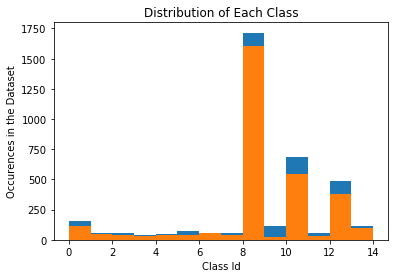

In [561]:
%matplotlib inline
plt.hist(ovo_predictions, bins=14)
plt.hist(t_train, bins=14)
plt.title("Distribution of Each Class")
plt.xlabel("Class Id")
plt.ylabel("Occurences in the Dataset")

In [563]:
t_train_1 = [1 if train_id != 8 else 0 for train_id in t_train]

In [567]:
# sanity check
(float(len(t_train)) - sum(t_train_1))/float(len(t_train))

0.5213869086195723

In [ ]:
t_train

In [577]:
RF = RandomForestClassifier(n_estimators=200)
RF.fit(X_train, t_train_1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [578]:
predictions_on_train = RF.predict(X_train)

In [579]:
len(predictions_on_train), len(t_train_1)

(3086, 3086)

In [581]:
amount = 0
for i in range(0, len(t_train_1)):
    if predictions_on_train[i] == t_train_1[i]:
        amount = amount + 1
amount / float(len(t_train_1))

0.9931950745301361

In [585]:
predictions_on_none = RF.predict(X_test)
class_for_none = [8 if none == 0 else 0for none in predictions_on_none]

In [610]:
len(RF_preds)

3724

In [614]:
new_rf_preds = []
for i in range(0, len(RF_preds)):
    if predictions_on_none[i] == 8:
        new_rf_preds.append(8)
    else:
        new_rf_preds.append(RF_preds[i])

In [615]:
len(new_rf_preds)

3724

In [630]:
from sklearn.preprocessing import normalize

In [633]:
RF_preds_normed = normalize(zip(*list(Counter(RF_preds).items()))[1])
new_rf_preds_normed = normalize(zip(*list(Counter(new_rf_preds).items()))[1])
t_train_normed = normalize(zip(*list(Counter(t_train).items()))[1])

In [641]:
RF_preds_normed

array([[ 0.07103677,  0.02985603,  0.03037079,  0.01904609,  0.02110513,
         0.03860694,  0.02985603,  0.03037079,  0.88950389,  0.05713827,
         0.35518385,  0.03088555,  0.25583532,  0.04118074,  0.01698705]])

In [650]:
new_rf_preds_normed

array([[ 0.07103677,  0.02985603,  0.03037079,  0.01904609,  0.02110513,
         0.03860694,  0.02985603,  0.03037079,  0.88950389,  0.05713827,
         0.35518385,  0.03088555,  0.25583532,  0.04118074,  0.01698705]])

In [651]:
t_train_normed

array([[ 0.06521052,  0.02860111,  0.02116482,  0.01830471,  0.02345291,
         0.02230886,  0.03031717,  0.02345291,  0.92038356,  0.01201246,
         0.31003598,  0.01830471,  0.21508031,  0.0337493 ,  0.02288088]])

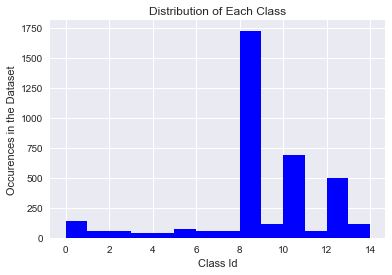

In [646]:
plt.hist(RF_preds, bins=14, color='g')
plt.hist(new_rf_preds, bins=14, color='b')
plt.title("Distribution of Each Class")
plt.xlabel("Class Id")
plt.ylabel("Occurences in the Dataset")

#### Outputting predictions

#### Previous Outputting predictions

In [ ]:
print "extracting test features..."
# get the test ids
X_test,_,t_ignore,test_ids = extract_feats(ffs, test_dir, global_feat_dict=global_feat_dict)
print "done extracting test features"

In [198]:
test_ids = pd.read_csv('rfpredictions.csv')['Id']

In [222]:
# df = pd.read_csv('test156feats.csv')
# df = df.drop(['Unnamed: 0'], axis=1)
X_test = np.matrix(best_test_df)

In [223]:
X_test.shape

(3724, 298)

In [522]:
util.write_predictions(etc_preds_156, test_ids, "etcpredictions156.csv")

In [224]:
RF_preds = RF.predict(X_test)

In [609]:
max(new_rf_preds), len(new_rf_preds), len(test_ids)

(14, 3086, 3724)

In [608]:
util.write_predictions(new_rf_preds, test_ids, "predswithlayer1.csv")

IndexError: list index out of range

In [538]:
# RF_preds = RF.predict(X_test)
print "writing predictions..."
util.write_predictions(RF_preds, test_ids, "rfpredictions160.csv")

writing predictions...


In [94]:
MNNB_preds = MNNB.predict(X_test)
print "writing predictions..."
util.write_predictions(MNNB_preds, test_ids, "mnnbpredictions.csv")

writing predictions...


In [96]:
lin_clf_preds = lin_clf.predict(X_test)
print "writing predictions..."
util.write_predictions(lin_clf_preds, test_ids, "svmpredictions.csv")

writing predictions...


In [703]:
def get_predictions(filename, filenametest):
    df = pd.read_csv(filename)
    df = df.drop(['Unnamed: 0'], axis=1)
    X_train = np.matrix(df)
    
    RF = RandomForestClassifier(n_estimators=1800)
    classifier = OneVsRestClassifier(RF, n_jobs=1000)
    print np.mean(cross_val_score(classifier, X_train, t_train, cv=5, scoring="accuracy"))
    classifier.fit(X_train, t_train)
    
    df_test = pd.read_csv(filenametest)
    df_test = df_test.drop(['Unnamed: 0'], axis=1)
    X_test = np.matrix(df_test)
    
    preds = classifier.predict(X_test)
    return preds

In [715]:
filename = 'train160feats.csv'
filenametest = 'test160feats.csv'
df = pd.read_csv(filename)
df = df.drop(['Unnamed: 0'], axis=1)
X_train = np.matrix(df)

RF = RandomForestClassifier(n_estimators=100)
classifier = OneVsOneClassifier(RF, n_jobs=100)
classifier.fit(X_train, t_train)
# preds = get_predictions(filename, filenametest)

ImportError: [joblib] Attempting to do parallel computing without protecting your import on a system that does not support forking. To use parallel-computing in a script, you must protect your main loop using "if __name__ == '__main__'". Please see the joblib documentation on Parallel for more information

In [ ]:
util.write_predictions(preds, test_ids, "final_preds/rf188predictions.csv")

### 2 layer

In [673]:
def construct_training(filename, filenametest):
    df = pd.read_csv(filename)
    df = df.drop(['Unnamed: 0'], axis=1)
    X_train = np.matrix(df) 
    t_train_1 = [1 if train_id != 8 else 0 for train_id in t_train]
    
    RF = RandomForestClassifier(n_estimators=100)
    print np.mean(cross_val_score(RF, X_train, t_train, cv=5, scoring="accuracy"))
    RF.fit(X_train, t_train)
    
    df_test = pd.read_csv(filenametest)
    df_test = df_test.drop(['Unnamed: 0'], axis=1)
    X_test = np.matrix(df_test)
    
    preds = RF.predict(X_test)
    return preds

In [672]:
filename = 'train160feats.csv'
filenametest = 'test160feats.csv'
df = pd.read_csv(filename)
df = df.drop(['Unnamed: 0'], axis=1)
X_train = np.matrix(df) 
t_train_1 = [1 if train_id != 8 else 0 for train_id in t_train]

In [679]:
RF_1 = RandomForestClassifier(n_estimators=100)
print np.mean(cross_val_score(RF, X_train, t_train_1, cv=5, scoring="accuracy"))
RF_1.fit(X_train, t_train_1)

0.932594749038


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [680]:
preds_malware = RF_1.predict(X_train)

In [697]:
df['malware'] = preds_malware
df.set_index(t_train)
df_malware = df_classes[df_classes['malware']]
t_train_2 = df_malware.index
X_train_2 = np.matrix(df_malware)

In [702]:
RF_2 = RandomForestClassifier(n_estimators=100)
print np.mean(cross_val_score(RF_2, X_train_2, t_train_2, cv=5, scoring="accuracy"))
RF_2.fit(X_train_2, t_train_2)

0.521410647401


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)